# Exercise Sheet 1b

In [4]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

import pandas as pd

# import os
# os.system('jupyter nbconvert --to html nearest-neighbor-commented.ipynb')

# 3. Nearest Neighbor Classification on Real Data

## 3.1 Exploring the Data

In [17]:
from sklearn.datasets import load_digits

digits = load_digits()
# print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
# print (data.dtype)

print("The total number of images is %i with dimensions of (%i, %i) pixels." %(images.shape))

The total number of images is 1797 with dimensions of (8, 8) pixels.


<span style="color:green;font-weight:bold"> Our code is essential equal to the code provided in the sample solution. The only difference is that we did not print the data type etc. </span>

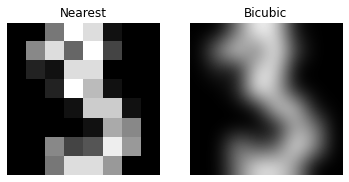

In [32]:
# find where the label is equal to 3 and return array position
pos_threes = np.where(target==3)[0]

# get first handwritten three
img = images[pos_threes[0]]
fig, axis = plt.subplots(nrows=1, ncols=2)

ax = axis[0]
ax.imshow(img, cmap="gray", interpolation="nearest")
ax.set_title("Nearest")
ax.axis("off")

ax = axis[1]
ax.imshow(img, cmap="gray", interpolation="bicubic")
ax.set_title("Bicubic")
ax.axis("off")

plt.show()

<span style="color:green;font-weight:bold"> Our solution is essentially equal, however, we did search in the labels for all instances of threes and picked the first one. Another approach would be to print out the labels and determine the position at which the first three occurs. This is what has been done in the sample solution. We think that our method using numpy.where() is more sophisticated and more robust to human error. Furthermore, it is easy to understand. In the sample solution, the interpolation='nearest' was used twice. We can't see the reason for this. </span>

Bicubic interpolation yields smoother results in contrast to nearest neighbor interpolation.

In [19]:
from sklearn.model_selection import train_test_split

X_all = data
y_all = target

# separate the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_all,
                                                    y_all,
                                                    test_size=0.4,
                                                    random_state=0)

<span style="color:green;font-weight:bold"> Our solution is essentially equal to the sample solution. </span>

## 3.2 Distance function computation using loops

In [20]:
def dist_loop(training, test):
    """
    Return a (N x M) distance matrix for a (N x D) and (M x D) input.

        training:   Training images with shape (N x D)
        test:       Test images with shape (M x D)
    """
    # make sure that inputs are arrays and no lists
    training = np.array(training)
    test = np.array(test)

    # get shapes of inputs
    N = training.shape[0]
    M = test.shape[0]

    # create (N x M) output
    distances = np.zeros((N, M))

    for n in range(N):
        for m in range(M):
            distances[n, m] = np.linalg.norm(training[n] - test[m])

    return distances

<span style="color:green;font-weight:bold"> Our solution is essentially the same as the sample solution. We also used two for loop iterations. </span>

In [21]:
def dist_vec(training, test):
    """
    Return a (N x M) distance matrix for a (N x D) and (M x D) input.

        training:   Training images with shape (N x D)
        test:       Test images with shape (M x D)
    """
    radicand =  (np.sum(training**2, axis=1) 
                + np.sum(test**2, axis=1)[:, np.newaxis] 
                - 2*np.dot(test, training.T))

    return np.sqrt(radicand.T)

<span style="color:green;font-weight:bold"> In our solution, we used a different approach than the one used in the sample solution. Instead of expanding the dimensions for the training and test matrices, we used the approach to expand $(x-y)^2 = x^2 + y^2 - 2xy$. In comparison to the sample solution, we did not discuss our approach in detail. </span>

In [33]:
distance_loop = dist_loop(X_train, X_test)
distance_vec = dist_vec(X_train, X_test)

# Test if all elements via the two methods are equal
if (distance_loop == distance_vec).all() == True:
    print("All elements generated by conventional for loops and vectorization are equal.")

All elements generated by conventional for loops and vectorization are equal.


<span style="color:green;font-weight:bold"> In comparison to the sample solution, our results from the functions using iteration and vectorization are completely equal. Most likely, this comes from the fact that in our solution the data type of the distance matrix was not set to be float64. </span>

In [23]:
import timeit

print("Execution time - Loop:")
%timeit distance_loop = dist_loop(X_train, X_test)
print("\nExecution time - Vectorization:")
%timeit distance_vec = dist_vec(X_train, X_test)

Execution time - Loop:
4.83 s ± 263 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Execution time - Vectorization:
12.1 ms ± 75.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As expected, the execution time using vectorization is reduced significantly in comparison to the conventional programming using for loops by a factor of $\approx 100$.

<span style="color:green;font-weight:bold"> Compared to the first sample solution, we also found a dramatic speed increase between the two types of calculation. In the first sample solution the speed increase from iteration to vectorization was $\approx 14$ times, whereas using our approach the speed increase was $\approx 400$ times faster, so we ecpect our approach to be way more efficient. We implemented the second proposed solution. </span>

## 3.4 Implement the k-nearest neighbor classifier

In [24]:
def accuracy_score(y, y_pred):
    # compare the arrays element-wise
    comparison = np.equal(y, y_pred)

    accuracy = np.count_nonzero(comparison) / len(y)
    return accuracy


def knn_classifier(X_train, X_test, y_train, k=1):

    distances = dist_vec(X_train, X_test)
    y_pred = np.array([])

    i = 0
    for x_test in X_test:

        # sort y_train according to distances, ascending order
        sorting = distances[:, i].argsort()
        y_train_sorted = y_train[sorting]

        # get k nearest neighbor labels
        k_nearest = y_train_sorted[0:k]

        # count number of occurences of the distinct classes
        unique, counts = np.unique(k_nearest, return_counts=True)
        dictionary = dict(zip(unique, counts))

        # retrieve key of dict with maximum occurence
        y_pred = np.append(y_pred, max(dictionary, key=dictionary.get))
        
        i += 1

    return y_pred.astype(int)

<span style="color:green;font-weight:bold"> Our solution differs to the sample solution. We think it is more efficient: In the sample solution, two for loops were used in order to calculate the counts. You defined a two-dimensional array counts initializing it with all zeros and then increasing the value to 1 in the counts[i,j] component. However, if you already know what the jth element in X_test has as label, you don't need to probe all other numbers. Essentially, of all queries, 9 out of 10 yield no result and could be left out. One could just probe the value in the jth component instead, and write the result in the [i,j]th component of the matrix, leading to a speed increase. (i = X_test[j], then counts[i, j] += 1). In our approach, we sort the labels 'y_train' according to the sorted distances 'sorting'. Then we take the first k elements, and count for each class how many instances of each class there are. Then, the result is given by the highest amount of occurences of this class, returning the class. </span>

In [25]:
# get the positions of images with labels 3s and 9s
pos_test = np.append(np.where(y_test==3), np.where(y_test==9))
pos_train = np.append(np.where(y_train==3), np.where(y_train==9))

# get the images and the corresponding labels of all 3s and 9s
X_test_39, X_train_39 = X_test[pos_test], X_train[pos_train]
y_test_39, y_train_39 = y_test[pos_test], y_train[pos_train]

# calculate the error rates for different values of k
ks = np.array([1, 3, 5, 9, 17, 33])
error_rates = []

for k in ks:
    y_pred_39 = knn_classifier(X_train_39, X_test_39, y_train_39, k=k)
    error = 1 - accuracy_score(y_test_39, y_pred_39)
    error_rates.append({
        "Error [%]": np.round(error * 100, 1),
        "k": k
    })

df_error = pd.DataFrame(error_rates)
df_error.set_index("k", inplace=True)
df_error.T

k           1    3    5    9    17   33
Error [%]  1.4  0.7  0.7  0.7  0.7  2.1

Using different values for the number of nearest neighbors $k$ taken into account for classification, we yield a relatively high prediction error for both small and high values.

For the minimal value $k=1$, it is probable for the single nearest neighbor to have a different class, leading directly to a wrong classification.

This effect is reduced when considering more nearest neighbors, however, if one chooses too many (e.g. $k = 33$), another effect comes into play: As the number of elements of each class is limited, elements from different classes are considered more and more as neirest neighbors for higher values of $k$. Therefore, the number of elements of each class has to be taken into account when choosing an appropriate $k$.

<span style="color:green;font-weight:bold"> Compared to the sample solution, we also calculated the error rate in percentage for different values of $k$ for labels $3$ and $9$. However, we did not plot the results. In the sample solution, you should not connect the points in a scatter plot via straight lines. Essentially, for the values, we yield the same results. The sample solution provided more information than asked in the task. In the sample solution, the task was implemented for all labels instead of just 3s and 9s. If you do additional stuff, please provide comments on what you wanted to show. We also checked how the error rates differ for different labels, but did not include it in our solution because it was not asked. </span>

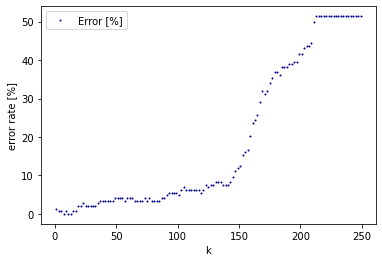

In [39]:
ks = np.arange(1, 251, 2)

error_rates = []
for k in ks:
    y_pred_39 = knn_classifier(X_train_39, X_test_39, y_train_39, k=k)
    error = 1 - accuracy_score(y_test_39, y_pred_39)
    error_rates.append({
        "Error [%]": np.round(error * 100, 2),
        "k": k
    })

df_error = pd.DataFrame(error_rates)
df_error.plot(x="k", y="Error [%]", marker=".", linestyle="none", color="darkblue", markersize="2")
plt.ylabel("error rate [%]")
plt.xlabel("k")
plt.show()

We also analyzed the prediction error for values of $k$ up to $250$, which is shown in the figure above. Here it can be seen that the prediction error is first decreasing to a global minimum at around $k \approx 11$ and increases afterwards. For $k > 200$ our classifier is not better than plain guessing.

# 4. Cross-validation

In [27]:
def split_folds(data, target, L):

    X_all = data
    y_all = target

    # create random indices set and shuffle
    rng = np.random.default_rng()
    indices = np.arange(y_all.shape[0])
    indices_shuffled = rng.permutation(indices)

    # apply shuffling on all data
    X_all = X_all[indices_shuffled]
    y_all = y_all[indices_shuffled]

    # split array in roughly equal subsets
    X_folds = np.array_split(X_all, L)
    y_folds = np.array_split(y_all, L)

    return np.array(X_folds), np.array(y_folds)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

def knn_classifier_sklearn(X_train, X_test, y_train, k=1):

    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    return y_pred

In [29]:
def cross_validation(X_all, y_all, L, k):

    # split the data into L equal folds
    X_split, y_split = split_folds(X_all, y_all, L)

    errors_sklearn, errors_ourself = np.array([]), np.array([])

    # iterate from l=1 to l=L
    for l in range(L):
        # use set l as test set and remaining as training sets
        X_test, y_test = X_split[l], y_split[l]
        X_train = np.concatenate(np.append(X_split[0:l], X_split[l+1:]))
        y_train = np.concatenate(np.append(y_split[0:l], y_split[l+1:]))

        # calculate predictions using sklearn and selfmade classifiers
        y_pred_sklearn = knn_classifier_sklearn(X_train, X_test, y_train, k=k)
        y_pred_ourself = knn_classifier(X_train, X_test, y_train, k=k)

        # calculate prediction errors
        err_sklearn = 100 * (1-accuracy_score(y_pred_sklearn, y_test))
        err_ourself = 100 * (1-accuracy_score(y_pred_ourself, y_test))
        errors_sklearn = np.append(errors_sklearn, err_sklearn)
        errors_ourself = np.append(errors_ourself, err_ourself)

    # calculate mean and standard deviation of prediction error
    err_mean_sklearn = np.mean(errors_sklearn)
    err_mean_ourself = np.mean(errors_ourself)
    err_std_sklearn = np.std(errors_sklearn)
    err_std_ourself = np.std(errors_ourself)

    return (err_mean_sklearn, err_std_sklearn), (err_mean_ourself, err_std_ourself)

<span style="color:green;font-weight:bold"> In the sample solution, all functions were implemented in a single function 'cross-validate'. It was explicitly asked to implement a function called 'split_folds', which is absorbed by this bigger function 'cross-validate'. We think that our solution is more tidy and more easily readable, as we have three different functions standing for themselves. This is also better for just using the knn without the need to cross-validate each time. Aside from this, our solution is more or less equal. </span>

In [45]:
# cross-validation of KNNs with different values of k = {1, 3, 5} and for L = {2, 5, 10}

ks = [1, 3, 5]
Ls = [2, 5, 10]

results = []
for k in ks:
    for L in Ls:
        error_ourself, error_sklearn = cross_validation(X_all, y_all, L, k)

        results.append({
            "k": k,
            "L": L,
            "Our own KNN [%]": np.round(error_ourself, 2),
            "Sklearn KNN [%]": np.round(error_sklearn, 2)
        })

print("Direct comparison of our own KNN implementation\nand the KNN implementation of sklearn:\n")

df_errors = pd.DataFrame(results)
df_errors = df_errors.groupby(["k", "L"]).first().unstack()
df_errors.T

Direct comparison of our own KNN implementation
and the KNN implementation of sklearn:



k                              1             3             5
                L                                           
Our own KNN [%] 2   [1.72, 0.39]  [1.73, 0.17]  [1.61, 0.06]
                5   [1.28, 0.52]  [1.22, 0.72]  [1.34, 0.48]
                10  [1.34, 0.62]  [1.11, 0.56]   [1.39, 0.8]
Sklearn KNN [%] 2   [1.72, 0.39]  [1.73, 0.17]  [1.61, 0.06]
                5   [1.28, 0.52]  [1.28, 0.82]  [1.34, 0.48]
                10  [1.34, 0.62]  [1.17, 0.58]   [1.39, 0.8]

The results from both our own implementation and sklearn's implementation of a KNN classifier are almost equal. In some rare cases, as can be seen for $k=3$, $L=5$, one can observe slightly different results. Our best guess are rounding errors during the calculation, as in most cases all other values are equal.

For the value of $k=3$, the mean prediction error decreases with increasing $L$. For $k=1$ and $k=5$, the mean prediction error first decreases for $L=5$, but then increases for $L=10$.

<span style="color:green;font-weight:bold"> Similar to the sample solution, our own knn implementation and the sklearn implementation yielded identical results. However, we did not compare shuffled and straight because we assumed in cross-validation you always shuffle. This was shown in the sample solution (the error rates of straight are always worse than those of shuffled). Opposed to the task on the exercise sheet, the sample solution did not provide solutions for different values of k. We repeated the task for $k= 1, 3, 5$. As far as we can see, only $k=5$ was used in the sample solution. The values in the sample solution are comparable to our results for $k=5$. </span>